## Audio Transfer Learning with Scikit-learn and Pytorch

We use pre-trained Pytorch models as audio feature extractors, and Scikit-learn classifiers are employed to rapidly prototype competent audio classifiers that can be trained on a CPU.

See the pipeline when using the VGGish model:

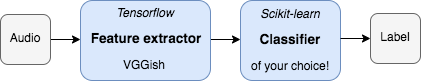


We will use the code within this [repository](https://github.com/LaiaTarres/TransferLearningMusic.git) to help with the implementation of the lab.

In [1]:
!git clone https://github.com/LaiaTarres/TransferLearningMusic.git

Cloning into 'TransferLearningMusic'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


Let's change the path so we can work with the code provided by the previously mentioned github.

In [2]:
%cd TransferLearningMusic

/content/TransferLearningMusic


#Loading the dataset

As an example, let's download the GTZAN dataset. This dataset can be found in the zip file, which you will have to upload to your google drive preferred location. Approximated download time: between 30 min and an hour. We already provide (fault-filtered) train/test partitions in sklearn-audio-transfer-learning/ data /index /GTZAN/. The dataset contains 10 classes and the scripts you need to run this notebook.

The configuration file, where we the paths and hyperparameters are provided

In [3]:
DATA_FOLDER = 'data/'
config = {
    'dataset': 'GTZAN',
    'num_classes_dataset': 10,
    'audio_folder': DATA_FOLDER + 'audio/GTZAN/genres/',
    'audio_paths_train': DATA_FOLDER + 'index/GTZAN/train_filtered.txt',
    'audio_paths_test': DATA_FOLDER + 'index/GTZAN/test_filtered.txt',
    'pca': False, # resulting number of dimensions to be reduced to (e.g., 128), or False to desactivate it
    'model_type': 'SVM', # 'linearSVM', 'SVM', 'perceptron', 'MLP', 'kNN'
    'load_training_data': 'training_data_GTZAN_vggish_pytorch.npz', # False or 'training_data_GTZAN_vggish_pytorch.npz', 
    'load_evaluation_data': 'evaluation_data_GTZAN_vggish_pytorch.npz' # False or 'evaluation_data_GTZAN_vggish.npz'
}

#Preparing the training data

We will take the vggish model pretrained as feature extractor. You can either extract the training features or load the training data. This las option has been done to save time. That way, loading [X, Y, IDS] takes less time than extracting them.

If you are interested in how the feature extraction works, check the extract_features_wrapper function.

In [14]:
!pip install soundfile

In [15]:
import numpy as np
import src.utils as utils
import src.vggish_input as vggish_input
import src.vggish_features as vggish_features
import torch


[paths_train, path2gt_train, path2onehot_train] = utils.load_path2gt(config['audio_paths_train'], config)
[paths_test, path2gt_test, path2onehot_test] = utils.load_path2gt(config['audio_paths_test'], config)

if config['load_training_data']:
        print('Loading training features..')
        training_data = np.load(DATA_FOLDER + 'audio_representations/' + config['load_training_data'])
        [X, Y, IDS] = [training_data['X'], training_data['Y'], training_data['IDS']]

else:
        print('Extracting training features..')
        #download the database if you haven't done it before, paste the following commands in another cell. Downoad in the folder: sklean-audio-tranfer-learning/data/audio
        #!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
        #!tar -zxvf genres.tar.gz
        #Model definition
        model_pytorch = torch.hub.load('harritaylor/torchvggish', 'vggish', preprocess=False)
        model_pytorch.eval()
        device_pytorch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_pytorch.to(device_pytorch)
        #Extracting the features by passing through the inputs to the model
        [X, Y, IDS] = vggish_features.extract_features_wrapper(paths_train, path2gt_train, model = model_pytorch, 
                                                               configuration = config, device = device_pytorch, 
                                                               save_as='training_data_{}_{}'.format(config['dataset'], 'vggish'), 
                                                               data_folder=DATA_FOLDER)
print('Done!')

Loading training features..
Done!


#Build an audio classifier

It is time to build the classifier. First, we will chose to do PCA feature reduction as indicated in the configuration file.

In [16]:
from sklearn import decomposition
if config['pca']: # for dimensionality reduction
        pca = decomposition.PCA(n_components=config['pca'], whiten=True)
        pca.fit(X)
        X = pca.transform(X)
        print("Shape after PCA: ", X.shape)
else:
        print("We don't do PCA. It's ok!")

We don't do PCA. It's ok!


Then, we will train the classifier chosen in the configuration file with the traning data.

In [17]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

def define_classification_model():
    """ Select and define the model you will use for the classifier. 
    """
    if config['model_type'] == 'linearSVM': # linearSVM can be faster than SVM
        return LinearSVC(C=1)
    elif config['model_type'] == 'SVM': # non-linearSVM, we can use the kernel trick
        return SVC(C=1, kernel='rbf', gamma='scale')
    elif config['model_type'] == 'kNN': # k-nearest neighbour
        return KNeighborsClassifier(n_neighbors=1, metric='cosine')
    elif config['model_type'] == 'perceptron': # otpimizes log-loss, also known as cross-entropy with sgd
        return SGDClassifier(max_iter=600, verbose=0.5, loss='log', learning_rate='optimal')
    elif config['model_type'] == 'MLP': # otpimizes log-loss, also known as cross-entropy with sgd
        return MLPClassifier(hidden_layer_sizes=(20,), max_iter=600, verbose=10, 
               solver='sgd', learning_rate='constant', learning_rate_init=0.001)
        
print('Fitting model..')
model = define_classification_model()
model.fit(X, Y)

Fitting model..


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Hurray! Now you have the classificator trained and ready to use. Let's evaluate it.

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

print('Evaluating model..')

if config['load_evaluation_data']:
        print('Loading evaluation features..')
        evaluation_data = np.load(DATA_FOLDER + 'audio_representations/' + config['load_evaluation_data'])
        [X_eval, IDS_eval] = [evaluation_data['X'], evaluation_data['IDS']]

else:
        print('Extracting evaluation features..')
        [X_eval, Y_eval, IDS_eval] = extract_features_wrapper(paths_test, path2gt_test, model='vggish', 
                                               save_as='evaluation_data_{}_{}'.format(config['dataset'], 'vggish'))

if config['pca']: # for dimensionality reduction
        X_eval = pca.transform(X_eval)
        print("Shape after PCA: ", X_eval.shape)

print('Predict labels on evaluation data')
pred = model.predict(X_eval)

y_pred = []
y_true = []
extension = IDS_eval[0].split('.')[-1] # find original extension
for pt in paths_test:
        tmp = pt.split('.')
        tmp[-1] = extension
        pt_extension = '.'.join(tmp) # fix extension
        y_pred.append(np.argmax(np.bincount(pred[np.where(IDS_eval==pt_extension)]))) # majority voting
        y_true.append(int(path2gt_test[pt]))

# print and store the results
conf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f'The model has achieved an accuracy of: {acc}')
print(f'The confusion matrix from this experiment: \n{conf_matrix}')

Evaluating model..
Loading evaluation features..
Predict labels on evaluation data
The model has achieved an accuracy of: 0.7689655172413793
The confusion matrix from this experiment: 
[[13  0  0  0  0 13  0  0  2  3]
 [ 0 31  0  0  0  0  0  0  0  0]
 [ 1  0 24  1  0  0  0  2  0  2]
 [ 0  0  0 24  0  0  0  3  2  0]
 [ 0  0  0  0 25  0  0  1  0  1]
 [ 0  2  0  0  0 25  0  0  0  0]
 [ 0  0  0  1  0  0 24  0  0  2]
 [ 0  0  0  1  3  0  0 24  0  2]
 [ 0  0  0  1  5  0  0  2 17  1]
 [ 2  0  3  2  0  0  4  4  1 16]]


Congrats, you have build a music genre classifier! The model we developed (VGGish + 100 PCA + SVM) achieved 77.93% accuracy in our test set.

#Results discussion

**1. Which setup gave you the best results? Any hypothesis why?**

<font color=”green”> YOUR ANSWER </font>

---
**2. Which setup gave you worst results? Any hypothesis why?**

<font color=”green”> YOUR ANSWER </font>

---
**3. Why do we get different results when running several times the same neural network-based experiment?**

<font color=”green”> YOUR ANSWER </font>